## 0. Imports Preliminaries

In [1]:
!pip install nltk py-readability-metrics spacy==3.6.1 keras==2.8

In [2]:
!pip install textatistic

In [3]:
#0. Preliminaries
import pandas as pd
import nltk, warnings
nltk.download('punkt')
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from readability import Readability

[nltk_data] Downloading package punkt to /home/lluneta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-01-20 19:41:55.982915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [5]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from textatistic import Textatistic

In [7]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

## 1. Load Data

In [8]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data_UTF8.csv")

In [9]:
df['Author'].value_counts()

Author
Aman Madaan     80
Zhiqing Sun     77
Timo Schick     76
Hugo Touvron    74
GPT-3.5         72
Name: count, dtype: int64

In [10]:
len(df)

379

## 2. Clean Data 

In [11]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string= re.sub(r'https?://[a-zA-Z0-9\n./-]+', "weblink", string)
    #string = re.sub(r'https?://[a-zA-Z0-9./-]+', "weblink", string) # remove links
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    # expression to remove \n or \t
    string = re.sub(r'[\n\t]', " ", string)
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [12]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [13]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [15]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [16]:
nlp = spacy.load("en_core_web_sm")

In [17]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

In [18]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [19]:
#df['flesch_score'] = df['Chunk'].apply(flesch_readability_scale)
def updated_Flesch_score(text):
    s = Textatistic(text)
    return s.flesch_score, s.word_count, s.sent_count, s.sybl_count

df[['flesch_score_v2','word_count', 'sent_count', 'sybl_count' ]] = df['Chunk'].apply(updated_Flesch_score).apply(pd.Series)

In [20]:
df['sent_score'] = df['Chunk'].apply(sentiment_analysis_score)

In [21]:
df['re_text'] = df['Chunk'].apply(regex)
#train has to be run first - a catch statement for that
df['re_text'] = df['re_text'].apply(remove_bullet_points)
#removing double space should be after removing bullet points! leaves a double space sometimes
df[['re_text', 'POS_string']] = df['re_text'].apply(POS_preprocessing)
df['lexical_diversity'] = df['re_text'].apply(lexical_diversity)
df['avg_word_per_sentence'] = df['re_text'].apply(avg_word_per_sentence)
df['avg_word_length'] = df['re_text'].apply(avg_word_length)

In [22]:
df['re_text'][38]

' This paper introduces a new task of politeness transfer which involves converting non polite sentences to polite sentences while preserving the meaning. We also provide a dataset of more than 0.00 million instances automatically labeled for politeness to encourage benchmark evaluations on this new task. We design a tag and generate pipeline that identifies stylistic attributes and subsequently generates a sentence in the target style while preserving most of the source content. For politeness as well as five other transfer tasks, our model outperforms the state of the art methods on automatic metrics for content preservation, with a comparable or better performance on style transfer accuracy. Additionally, our model surpasses existing methods on human evaluations for grammaticality, meaning preservation and transfer accuracy across all the six style transfer tasks. The data and code is located at weblink'

In [23]:
df.to_csv("../data/df_with_features.csv")

In [24]:
#df = pd.read_csv("../data/df_with_features.csv")

In [25]:
#df = df.drop(columns="text")

## Inspect Features

In [26]:
feature_stats = df[['Author', 'flesch_score_v2', 'word_count', 'sent_count', 'sybl_count', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']].groupby('Author').mean().reset_index()

In [27]:
feature_stats

,Author,flesch_score_v2,word_count,sent_count,sybl_count,sent_score,lexical_diversity,avg_word_per_sentence,avg_word_length
0,Aman Madaan,45.299416,184.325000,7.675000,295.875000,0.473754,0.588675,25.818679,5.099534
1,GPT-3.5,27.734640,140.638889,6.125000,258.541667,0.645164,0.658798,25.606840,5.728179
2,Hugo Touvron,46.661486,187.148649,8.418919,300.459459,0.528844,0.601665,25.180966,5.055554
3,Timo Schick,45.373690,185.144737,6.421053,285.460526,0.453588,0.602757,31.120298,4.998578
4,Zhiqing Sun,42.573211,198.311688,7.870130,320.077922,0.501180,0.575078,27.670971,5.311459


In [28]:
statistics = df[['Author', 'sybl_count', 'word_count', 'sent_count']].groupby("Author").mean().reset_index()
statistics['word_sent_ratio'] = statistics.word_count/statistics.sent_count
statistics['syl_word_ratio'] = statistics.sybl_count/statistics.word_count

In [29]:
statistics

,Author,sybl_count,word_count,sent_count,word_sent_ratio,syl_word_ratio
0,Aman Madaan,295.875000,184.325000,7.675000,24.016287,1.605181
1,GPT-3.5,258.541667,140.638889,6.125000,22.961451,1.838337
2,Hugo Touvron,300.459459,187.148649,8.418919,22.229535,1.605459
3,Timo Schick,285.460526,185.144737,6.421053,28.834016,1.541824
4,Zhiqing Sun,320.077922,198.311688,7.870130,25.198020,1.614014


In [30]:
#feature_stats.to_clipboard(float_format='%.2f', index=False)

In [31]:
#statistics.to_clipboard(float_format='%.2f', index=False)

### Compare with GPT-data

In [32]:
GPT_data = pd.read_csv("../data/GPT_data_UTF8_additional_2.csv")

In [33]:
GPT_data = GPT_data.reset_index(drop = True)
df_w_features_GPT = df[df['Author'] == "GPT-3.5"].reset_index(drop = True)
df_w_features_GPT['Author_org'] = ""

for df_row in df_w_features_GPT.index:
    text = df_w_features_GPT.loc[df_row, 'Chunk'][1:500]
    type_text= df_w_features_GPT.loc[df_row, 'Type']
    col_type = "GPT_abstract" if type_text == "abstract_chunked" else ("GPT_introduction" if type_text == "intro_chunked" else "GPT_conclusion")
    for texts in GPT_data.index:
        if text in GPT_data.loc[texts, col_type]:
            df_w_features_GPT.loc[df_row, 'Author_org'] = GPT_data.loc[texts, 'Author']

In [34]:
df_w_features_GPT.loc[df_w_features_GPT['Author_org'] == "", :]

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score_v2,word_count,sent_count,sybl_count,sent_score,re_text,POS_string,lexical_diversity,avg_word_per_sentence,avg_word_length,Author_org
34,10,GPT-3.5,"["" The ubiquity of machine learning, particula...",intro_chunked,"The ubiquity of machine learning, particularl...",19.324064,190.0,9.0,373.0,0.600239,"The ubiquity of machine learning, particularl...",DET NOUN ADP NOUN NOUN PUNCT ADV ADJ NOUN PUN...,0.588785,23.777778,5.920561,
58,10,GPT-3.5,"[' In the evolving landscape of deep learning,...",conclusion_chunked,"In the evolving landscape of deep learning, t...",21.289020,211.0,8.0,396.0,0.731827,"In the evolving landscape of deep learning, t...",ADP DET VERB NOUN ADP ADJ NOUN PUNCT DET NOUN...,0.587983,29.125000,5.759657,
59,11,GPT-3.5,"["" In conclusion, ResMLP presents a compelling...",conclusion_chunked,"In conclusion, ResMLP presents a compelling a...",28.295437,166.0,8.0,309.0,0.753702,"In conclusion, Propname presents a compelling...",ADP NOUN PUNCT PROPN VERB DET ADJ NOUN ADP AD...,0.646739,23.000000,5.951087,


In [35]:
#checked manually
df_w_features_GPT.loc[df_w_features_GPT['Author_org'] == "", "Author_org"] = "Hugo Touvron"

In [36]:
stats_GPT_v_authors = df_w_features_GPT[['Author_org', 'flesch_score_v2', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']].groupby('Author_org').mean().reset_index()

In [37]:
stats_GPT_v_authors

,Author_org,flesch_score_v2,sent_score,lexical_diversity,avg_word_per_sentence,avg_word_length
0,Aman Madaan,32.125885,0.687582,0.671689,25.908862,5.552686
1,Hugo Touvron,25.505675,0.637454,0.655178,24.541821,5.804249
2,Timo Schick,27.150230,0.668909,0.673943,26.067725,5.771274
3,Zhiqing Sun,26.156769,0.586711,0.634382,25.908951,5.784505


In [38]:
stats_GPT_v_authors.to_csv("test_gpt.csv", float_format='%.2f', index=False)

# 3. Split Data

In [39]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.7
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]
#df_test, df_val  = train_test_split(df_test_val, train_size = 0.5, stratify = df_test_val['Author'], random_state = 42)

In [40]:
df_train['Author'].value_counts()

Author
Aman Madaan     37
GPT-3.5         37
Hugo Touvron    37
Timo Schick     37
Zhiqing Sun     37
Name: count, dtype: int64

In [41]:
df_val['Author'].value_counts()

Author
Aman Madaan     13
Zhiqing Sun     12
Hugo Touvron    11
Timo Schick      9
GPT-3.5          6
Name: count, dtype: int64

In [42]:
df_test_0['Author'].value_counts()

Author
Zhiqing Sun     13
Aman Madaan     13
Hugo Touvron    11
Timo Schick     10
GPT-3.5          5
Name: count, dtype: int64

In [43]:
df_test_1['Author'].value_counts()

Author
GPT-3.5         24
Timo Schick     20
Aman Madaan     17
Hugo Touvron    15
Zhiqing Sun     15
Name: count, dtype: int64

In [44]:
df_test = pd.concat([df_test_0, df_val])
print(df_test['Author'].value_counts())

Author
Aman Madaan     26
Zhiqing Sun     25
Hugo Touvron    22
Timo Schick     19
GPT-3.5         11
Name: count, dtype: int64


In [45]:
len(df_test_1)

91

In [46]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [47]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [48]:
stopword_vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [49]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# 4. Tokenize Datasets

In [50]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def clean_punct(test_str):
    for ele in test_str:
        if ele in punc:
            test_str = test_str.replace(ele, "")
    return test_str

In [51]:
def remove_stopwords(example_text):
    word_tokens = word_tokenize(example_text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords.words("english")]
    return " ".join(filtered_sentence)

In [52]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")

    #lowercase everything
    df[text_col] = df[text_col].apply(str.lower)
    df[text_col] = df[text_col].apply(clean_punct)

    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")

    #remove stopwords here
    df[text_col] = df[text_col].apply(remove_stopwords)
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [53]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)

In [54]:
df_val_processed = preprocess_data(df_val, 're_text', train = False)

In [55]:
df_test_0_processed = preprocess_data(df_test_0, 're_text', train = False)

In [56]:
df_test_1_processed = preprocess_data(df_test_1, 're_text', train = False)

In [57]:
# df_val_processed.to_pickle("./df_val_processed.pkl")
# df_test_0_processed.to_pickle("./df_test_0_processed.pkl")
# df_test_1_processed.to_pickle("./df_test_1_processed.pkl")

In [58]:
X_train_df = df_train_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count"])
colnames_reg = X_train_df.columns
y_train = df_train_processed['Author']

X_val_df = df_val_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count"])
y_val = df_val_processed['Author']

X_test_0_df = df_test_0_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count"])
y_test_0 = df_test_0_processed['Author']

X_test_1_df = df_test_1_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "word_count", "sent_count", "sybl_count"])
y_test_1 = df_test_1_processed['Author']

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

In [60]:
X_test_0_scaled = scaler.transform(X_test_0_df)
X_test_1_scaled = scaler.transform(X_test_1_df)

# 5. Exploring the features

## Feature correlation

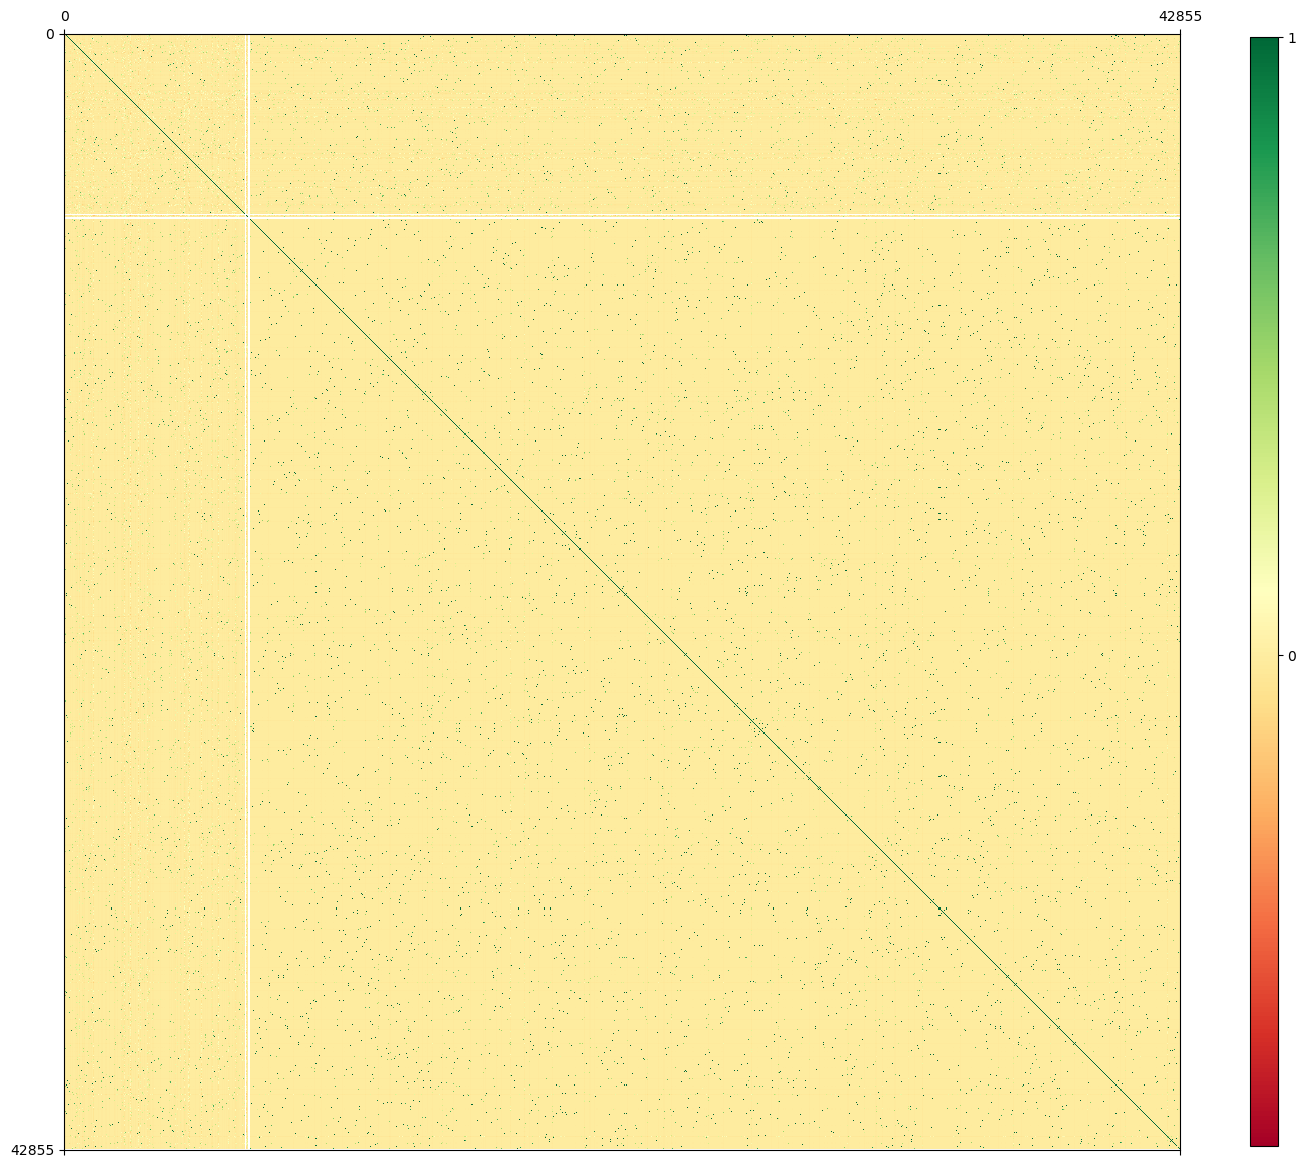

In [61]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch

def plot_corr(df, size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    # Don't use df.corr() as it is is extremely slow
    corr = np.corrcoef(df.T)
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    ax.set_xticks([0, len(corr)])
    ax.set_yticks([0, len(corr)])
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

plot_corr(X_train_df, size=18)

### Crafted features

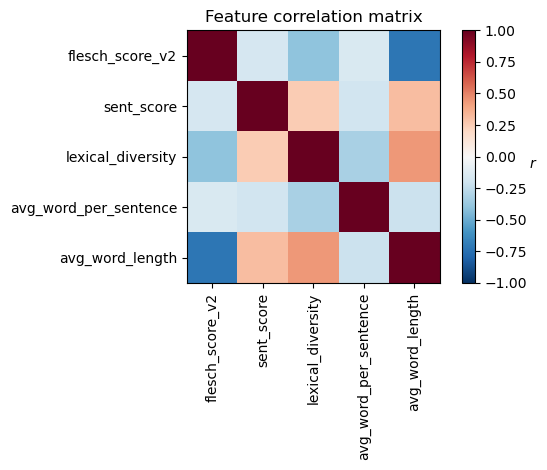

In [62]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = colnames_reg.values.tolist()

ax = plt.axes()

target_features = ['flesch_score_v2', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']
assert [f for f in X_train_df.columns if not f.startswith('punct_') and not f.startswith('word_') and not f.startswith('pos_') and not f.startswith('stop_')] == target_features

im = ax.imshow(np.corrcoef(X_train_df[target_features].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(target_features))))
ax.set_xticklabels(target_features, rotation=90)
ax.set_yticks(list(range(len(target_features))))
ax.set_yticklabels(list(target_features))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()

### Principal Component Analysis

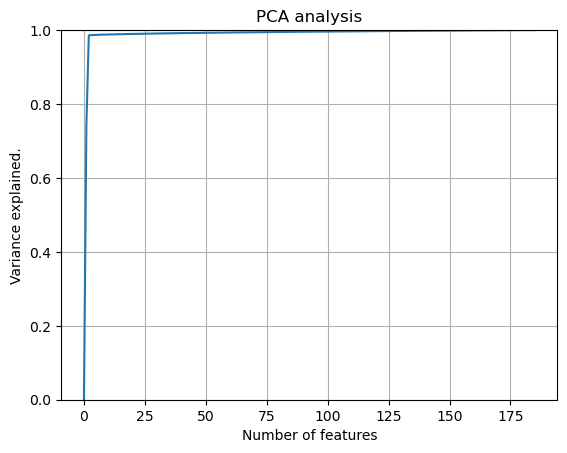

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

feature_names = colnames_reg.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train_df.index)), random_state = 42)
pca.fit_transform(X_train_df)
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
var_explained = pca.explained_variance_ratio_.cumsum()
var_explained = np.insert(var_explained, 0, 0)

components = list(range(len(var_explained)))
ax.plot(components, var_explained)
ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()

In [64]:
# Keep only the first 25 components.
pca = PCA(n_components=25, random_state = 42)
X_train_pca = pca.fit_transform(X_train_df)
X_val_pca = pca.transform(X_val_df)
X_test_0_pca = pca.transform(X_test_0_df)
X_test_1_pca = pca.transform(X_test_1_df)


# 6. Modelling

In [65]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 

## Grid search

### Logistic regression

In [66]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Also suppress warnings in other processes during grid search.
os.environ["PYTHONWARNINGS"] = "ignore"
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def grid_search(model, params, X_scaled, X_pca, y, cv=KFold(5, shuffle=True, random_state=42)):
    X_scaled = np.nan_to_num(X_scaled)
    X_pca = np.nan_to_num(X_pca)
    y = np.nan_to_num(y)
    gridSearch_scaled = GridSearchCV(model, params, cv=cv, verbose=1, n_jobs=128)
    gridSearch_scaled.fit(X_scaled, y)
    gridSearch_pca = GridSearchCV(model, params, cv=cv, verbose=1, n_jobs=128)
    gridSearch_pca.fit(X_pca, y)
    return gridSearch_scaled, gridSearch_pca

In [67]:
logi_scaled, logi_pca = grid_search(
    Pipeline([('logi', LogisticRegression())]),
    {'logi__penalty': ['l2', 'l1'],
     'logi__solver': ['saga'],
     'logi__random_state': [42]},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [68]:
logi_scaled_best_params = pd.DataFrame.from_dict(logi_scaled.cv_results_).sort_values(by=['rank_test_score'])
logi_scaled_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logi__penalty,param_logi__random_state,param_logi__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.751005,0.029249,0.044313,0.012108,l2,42,saga,"{'logi__penalty': 'l2', 'logi__random_state': ...",0.810811,0.837838,0.702703,0.864865,0.810811,0.805405,0.055125,1
1,27.317073,0.049464,0.043571,0.018724,l1,42,saga,"{'logi__penalty': 'l1', 'logi__random_state': ...",0.702703,0.702703,0.783784,0.810811,0.837838,0.767568,0.055652,2


In [69]:
logi_pca_best_params = pd.DataFrame.from_dict(logi_pca.cv_results_).sort_values(by=['rank_test_score'])
logi_pca_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logi__penalty,param_logi__random_state,param_logi__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014294,0.000151,0.037878,0.011352,l2,42,saga,"{'logi__penalty': 'l2', 'logi__random_state': ...",0.540541,0.594595,0.486486,0.513514,0.540541,0.535135,0.035855,1
1,0.016998,0.000178,0.044163,0.010458,l1,42,saga,"{'logi__penalty': 'l1', 'logi__random_state': ...",0.513514,0.594595,0.432432,0.459459,0.459459,0.491892,0.057714,2


### Random forest

In [70]:
rf_scaled, rf_pca = grid_search(
    Pipeline([('rf', RandomForestClassifier())]),
    {'rf__n_estimators': [10, 100, 500, 1000],
     'rf__criterion': ['gini', 'entropy'],
     'rf__random_state': [42]},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [71]:
rf_scaled_best_params = pd.DataFrame.from_dict(rf_scaled.cv_results_).sort_values(by=['rank_test_score'])
rf_scaled_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,param_rf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,2.703099,0.096019,0.038252,0.001701,gini,500,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.729730,0.702703,0.837838,0.837838,0.729730,0.767568,0.058218,1
3,4.268848,0.130049,0.068234,0.002127,gini,1000,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.729730,0.702703,0.810811,0.837838,0.729730,0.762162,0.052407,2
7,4.385288,0.097961,0.067152,0.001696,entropy,1000,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.702703,0.648649,0.783784,0.783784,0.675676,0.718919,0.055652,3
6,2.593662,0.080456,0.037534,0.000810,entropy,500,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.702703,0.648649,0.756757,0.729730,0.675676,0.702703,0.038222,4
1,0.863161,0.073308,0.012242,0.000815,gini,100,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.621622,0.702703,0.783784,0.729730,0.621622,0.691892,0.063037,5
5,0.785710,0.041657,0.012504,0.000778,entropy,100,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.648649,0.567568,0.729730,0.702703,0.675676,0.664865,0.055652,6
0,0.307819,0.091092,0.007043,0.000902,gini,10,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.540541,0.540541,0.459459,0.459459,0.351351,0.470270,0.069644,7
4,0.306520,0.011942,0.007117,0.000545,entropy,10,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.459459,0.486486,0.324324,0.594595,0.486486,0.470270,0.086486,7


In [72]:
rf_pca_best_params = pd.DataFrame.from_dict(rf_pca.cv_results_).sort_values(by=['rank_test_score'])
rf_pca_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,param_rf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.168837,0.015487,0.062118,0.001571,gini,1000,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.810811,0.702703,0.702703,0.756757,0.756757,0.745946,0.040450,1
6,0.727776,0.032035,0.031742,0.000717,entropy,500,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.810811,0.675676,0.729730,0.756757,0.756757,0.745946,0.043914,1
7,1.341391,0.024798,0.061851,0.000823,entropy,1000,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.810811,0.702703,0.729730,0.729730,0.756757,0.745946,0.036661,1
2,0.632698,0.039113,0.031478,0.000672,gini,500,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.837838,0.648649,0.648649,0.756757,0.756757,0.729730,0.072521,4
5,0.175303,0.030850,0.007430,0.001433,entropy,100,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.783784,0.675676,0.702703,0.783784,0.594595,0.708108,0.071302,5
1,0.146289,0.021951,0.007282,0.000956,gini,100,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.729730,0.594595,0.675676,0.783784,0.648649,0.686486,0.065314,6
0,0.021110,0.003195,0.001897,0.000304,gini,10,42,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.621622,0.540541,0.675676,0.567568,0.648649,0.610811,0.050128,7
4,0.021409,0.004319,0.001666,0.000376,entropy,10,42,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.648649,0.594595,0.540541,0.540541,0.621622,0.589189,0.043243,8


### Support vector classification

In [73]:
svc_scaled, svc_pca = grid_search(
    Pipeline([('svc', SVC())]),
    {'svc__kernel': ['linear', 'rbf', 'poly'],
     'svc__C': [0.5, 1., 2.],
     'svc__random_state': [42]},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [74]:
svc_scaled_best_params = pd.DataFrame.from_dict(svc_scaled.cv_results_).sort_values(by=['rank_test_score'])
svc_scaled_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,param_svc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.581229,0.994704,0.759931,0.371077,0.5,linear,42,"{'svc__C': 0.5, 'svc__kernel': 'linear', 'svc_...",0.756757,0.243243,0.486486,0.648649,0.432432,0.513514,0.177640,1
3,9.997820,0.600014,0.682794,0.213857,1.0,linear,42,"{'svc__C': 1.0, 'svc__kernel': 'linear', 'svc_...",0.756757,0.243243,0.486486,0.648649,0.432432,0.513514,0.177640,1
6,10.241311,0.769485,0.896005,0.358909,2.0,linear,42,"{'svc__C': 2.0, 'svc__kernel': 'linear', 'svc_...",0.756757,0.243243,0.486486,0.648649,0.432432,0.513514,0.177640,1
7,9.037077,0.565395,1.276693,0.307585,2.0,rbf,42,"{'svc__C': 2.0, 'svc__kernel': 'rbf', 'svc__ra...",0.405405,0.459459,0.243243,0.486486,0.324324,0.383784,0.089475,4
4,9.768749,1.055734,0.715952,0.365895,1.0,rbf,42,"{'svc__C': 1.0, 'svc__kernel': 'rbf', 'svc__ra...",0.324324,0.270270,0.243243,0.378378,0.324324,0.308108,0.047123,5
8,8.862065,1.179038,1.053863,0.321391,2.0,poly,42,"{'svc__C': 2.0, 'svc__kernel': 'poly', 'svc__r...",0.243243,0.135135,0.162162,0.216216,0.243243,0.200000,0.043914,6
5,9.451012,0.548932,0.899536,0.458955,1.0,poly,42,"{'svc__C': 1.0, 'svc__kernel': 'poly', 'svc__r...",0.243243,0.135135,0.162162,0.216216,0.189189,0.189189,0.038222,7
2,9.893331,0.430626,0.749191,0.267021,0.5,poly,42,"{'svc__C': 0.5, 'svc__kernel': 'poly', 'svc__r...",0.108108,0.135135,0.108108,0.216216,0.108108,0.135135,0.041870,8
1,10.111017,0.712870,0.569175,0.265101,0.5,rbf,42,"{'svc__C': 0.5, 'svc__kernel': 'rbf', 'svc__ra...",0.108108,0.135135,0.108108,0.162162,0.135135,0.129730,0.020225,9


In [75]:
svc_pca_best_params = pd.DataFrame.from_dict(svc_pca.cv_results_).sort_values(by=['rank_test_score'])
svc_pca_best_params

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,param_svc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.019633,0.006160,0.000694,0.000112,1.0,linear,42,"{'svc__C': 1.0, 'svc__kernel': 'linear', 'svc_...",0.783784,0.621622,0.756757,0.756757,0.837838,0.751351,0.071302,1
6,0.029894,0.009131,0.000674,0.000040,2.0,linear,42,"{'svc__C': 2.0, 'svc__kernel': 'linear', 'svc_...",0.756757,0.621622,0.756757,0.783784,0.810811,0.745946,0.065314,2
0,0.011601,0.002040,0.000663,0.000058,0.5,linear,42,"{'svc__C': 0.5, 'svc__kernel': 'linear', 'svc_...",0.702703,0.756757,0.702703,0.702703,0.783784,0.729730,0.034187,3
4,0.003478,0.000233,0.000945,0.000141,1.0,rbf,42,"{'svc__C': 1.0, 'svc__kernel': 'rbf', 'svc__ra...",0.486486,0.405405,0.243243,0.324324,0.432432,0.378378,0.085467,4
7,0.003249,0.000560,0.000796,0.000136,2.0,rbf,42,"{'svc__C': 2.0, 'svc__kernel': 'rbf', 'svc__ra...",0.432432,0.378378,0.243243,0.351351,0.432432,0.367568,0.069644,5
1,0.003425,0.000563,0.000874,0.000158,0.5,rbf,42,"{'svc__C': 0.5, 'svc__kernel': 'rbf', 'svc__ra...",0.486486,0.405405,0.243243,0.324324,0.351351,0.362162,0.081261,6
5,0.003290,0.000449,0.000713,0.000081,1.0,poly,42,"{'svc__C': 1.0, 'svc__kernel': 'poly', 'svc__r...",0.405405,0.297297,0.135135,0.351351,0.324324,0.302703,0.091094,7
8,0.003288,0.000489,0.000567,0.000081,2.0,poly,42,"{'svc__C': 2.0, 'svc__kernel': 'poly', 'svc__r...",0.378378,0.324324,0.162162,0.297297,0.351351,0.302703,0.075289,7
2,0.003532,0.000339,0.000812,0.000071,0.5,poly,42,"{'svc__C': 0.5, 'svc__kernel': 'poly', 'svc__r...",0.405405,0.297297,0.108108,0.297297,0.297297,0.281081,0.096089,9


## Run the best models from each gridsearch

In [76]:
#merge val and test_0
X_test_scaled = np.concatenate((X_val_scaled, X_test_0_scaled))

In [77]:
print(X_val_scaled.shape)
print(X_test_0_scaled.shape)
print(X_test_scaled.shape)

(51, 42855)
(52, 42855)
(103, 42855)


In [78]:
X_test_pca = np.concatenate((X_val_pca, X_test_0_pca))

In [79]:
y_test = np.concatenate((y_val, y_test_0))

In [80]:
def run_classifier(X_val, X_test, model):
    # Make predictions on the test set
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_1 = model.predict(X_test)
    # Evaluate the accuracy of the model
    return y_pred, y_pred_1

In [81]:
# from sklearn.inspection import permutation_importance
# perm_importance = permutation_importance(SVC_model, X_test_scaled, y_test)
# features_array = np.array(colnames_reg)
# sorted_idx = perm_importance.importances_mean.argsort()
# sorted_idx_10 = sorted_idx[0:10]
# plt.barh(features_array[sorted_idx_10], perm_importance.importances_mean[sorted_idx_10])
# plt.xlabel("Permutation Importance")

In [82]:
import eli5

In [83]:
#1. SVC
params = svc_scaled_best_params.iloc[0].params
assert params == {'svc__C': 0.5, 'svc__kernel': 'linear', 'svc__random_state': 42}
SVC_model = SVC(kernel = params['svc__kernel'], C = params['svc__C'], random_state = 42)
SVC_model.fit(X_train_scaled, y_train)
predictions_SVC, predictions_SVC_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, SVC_model)

In [84]:
#1a. SVC PCA
params = svc_pca_best_params.iloc[0].params
assert params == {'svc__C': 1.0, 'svc__kernel': 'linear', 'svc__random_state': 42}
SVC_model_pca = SVC(kernel = params['svc__kernel'], C = params['svc__C'], random_state = 42)
SVC_model_pca.fit(X_train_pca, y_train)
predictions_SVC_pca, predictions_SVC_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, SVC_model_pca)

In [85]:
#2. RF
params = rf_scaled_best_params.iloc[0].params
assert params == {'rf__criterion': 'gini', 'rf__n_estimators': 500, 'rf__random_state': 42}
RF_model = RandomForestClassifier(criterion = params['rf__criterion'], n_estimators = params['rf__n_estimators'], random_state = 42)
RF_model.fit(X_train_scaled, y_train)
predictions_RF, predictions_RF_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, RF_model)

In [86]:
#2a. RF PCA
params = rf_pca_best_params.iloc[0].params
assert params == {'rf__criterion': 'gini', 'rf__n_estimators': 1000, 'rf__random_state': 42}
RF_model_pca = RandomForestClassifier(criterion = params['rf__criterion'], n_estimators = params['rf__n_estimators'], random_state = 42)
RF_model_pca.fit(X_train_pca, y_train)
predictions_RF_pca, predictions_RF_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, RF_model_pca)

In [87]:
forest_importances = pd.Series(RF_model.feature_importances_, index=colnames_reg)

In [88]:
forest_importances.sort_values(ascending=False).head(50)

avg_word_length            0.006301
flesch_score_v2            0.005579
pos_noun punct verb        0.003411
stop_the                   0.003349
word_image                 0.003036
stop_this                  0.002935
word_language              0.002764
pos_noun pron              0.002750
pos_pron aux               0.002737
lexical_diversity          0.002675
pos_noun punct pron        0.002671
pos_punct verb             0.002581
pos_adj noun adp verb      0.002579
stop_to                    0.002425
pos_punct adp              0.002381
word_training              0.002320
word_reasoning             0.002266
pos_adp noun               0.002222
sent_score                 0.002222
pos_noun adp noun          0.002174
stop_it                    0.002136
pos_noun adp adj noun      0.002115
pos_verb pron              0.002097
word_paper                 0.002080
pos_noun verb              0.002075
pos_noun num               0.002071
pos_adj noun punct verb    0.002035
word_model                 0

In [89]:
#3. LR
#same parameters for all data and final 
params = logi_scaled_best_params.iloc[0].params
assert params == {'logi__penalty': 'l2', 'logi__random_state': 42, 'logi__solver': 'saga'}
LR_model = LogisticRegression(penalty = params['logi__penalty'], solver = params['logi__solver'], random_state = 42)
LR_model.fit(X_train_scaled, y_train)

params = logi_pca_best_params.iloc[0].params
assert params == {'logi__penalty': 'l2', 'logi__random_state': 42, 'logi__solver': 'saga'}
LR_model_pca = LogisticRegression(penalty = params['logi__penalty'], solver = params['logi__solver'], random_state = 42)

LR_model_pca.fit(X_train_pca, y_train)
predictions_LR, predictions_LR_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, LR_model)
predictions_LR_pca, predictions_LR_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, LR_model_pca)

In [90]:
df_test_final = pd.concat([df_val, df_test_0])
df_test_final['prediction_SVC'] = predictions_SVC
df_test_final['prediction_SVC_pca'] = predictions_SVC_pca
df_test_final['prediction_RF'] = predictions_RF
df_test_final['prediction_RF_pca'] = predictions_RF_pca
df_test_final['prediction_LR'] = predictions_LR
df_test_final['prediction_LR_pca'] = predictions_LR_pca
df_test_final.to_csv("../data/predictions_test_v2.csv")

In [91]:
df_test_1.loc[:, 'prediction_SVC'] = predictions_SVC_conclusion
df_test_1.loc[:, 'prediction_SVC_pca'] = predictions_SVC_pca_conclusion
df_test_1.loc[:, 'prediction_RF'] = predictions_RF_conclusion
df_test_1.loc[:, 'prediction_RF_pca'] = predictions_RF_pca_conclusion
df_test_1.loc[:, 'prediction_LR'] = predictions_LR_conclusion
df_test_1.loc[:, 'prediction_LR_pca'] = predictions_LR_pca_conclusion
df_test_1.to_csv("../data/predictions_test_conclusion_v2.csv")

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, precision_score

default_metrics = {
    'accuracy': accuracy_score,
    'recall': lambda y_t, y_p: recall_score(y_t, y_p, zero_division="warn", average='micro'),
    'precision': lambda y_t, y_p: precision_score(y_t, y_p, zero_division="warn", average='micro'),
    'f1': lambda y_t, y_p: f1_score(y_t, y_p, zero_division= "warn", average ='macro')
}

mapping_authors = {'Aman Madaan': 1, 'Hugo Touvron': 2, 'Timo Schick': 3, 'Zhiqing Sun': 4,'GPT-3.5': 5}
def plot_accuracy(df, column, metrics):
    y_true = df['Author'].map(mapping_authors)
    y_pred = df[column].map(mapping_authors)

    # Remove labels and display_labels not present in y_true
    labels = [1, 2, 3, 4, 5]
    display_labels = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'GPT-3.5']

    # Plot count confusion matrix
    cm_disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, display_labels=display_labels)

    # Show plot
    plt.show()

    # Calculate metrics
    metrics = {metric_name: metric_func(y_true, y_pred) for metric_name, metric_func in metrics.items()}
    print(metrics)

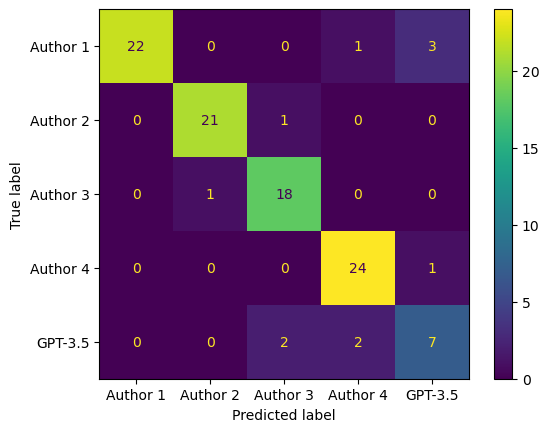

{'accuracy': 0.8932038834951457, 'recall': 0.8932038834951457, 'precision': 0.8932038834951457, 'f1': 0.8661305361305361}


In [93]:
plot_accuracy(df_test_final, 'prediction_LR', default_metrics)

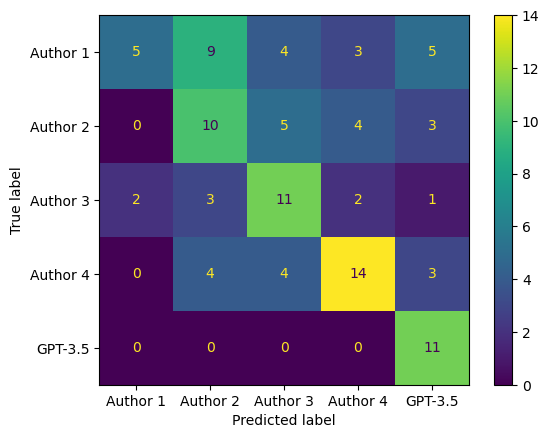

{'accuracy': 0.49514563106796117, 'recall': 0.49514563106796117, 'precision': 0.49514563106796117, 'f1': 0.4923434067072918}


In [94]:
plot_accuracy(df_test_final, 'prediction_LR_pca', default_metrics)

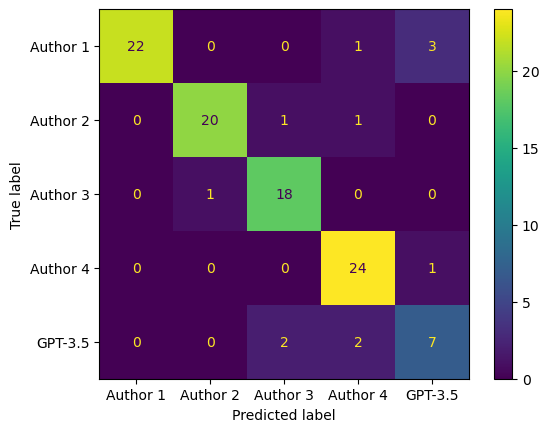

{'accuracy': 0.883495145631068, 'recall': 0.883495145631068, 'precision': 0.883495145631068, 'f1': 0.8577846477056656}


In [95]:
plot_accuracy(df_test_final, 'prediction_SVC', default_metrics)

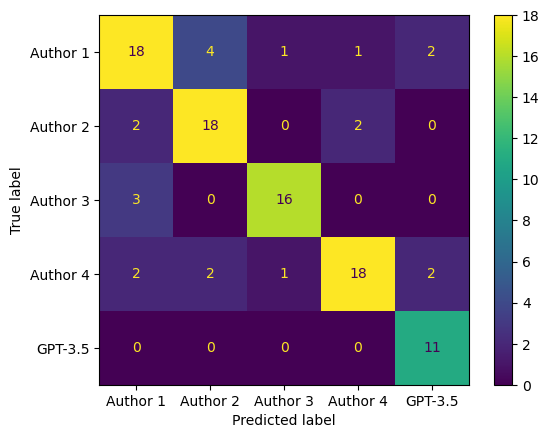

{'accuracy': 0.7864077669902912, 'recall': 0.7864077669902912, 'precision': 0.7864077669902912, 'f1': 0.796423691052847}


In [96]:
plot_accuracy(df_test_final, 'prediction_SVC_pca', default_metrics)

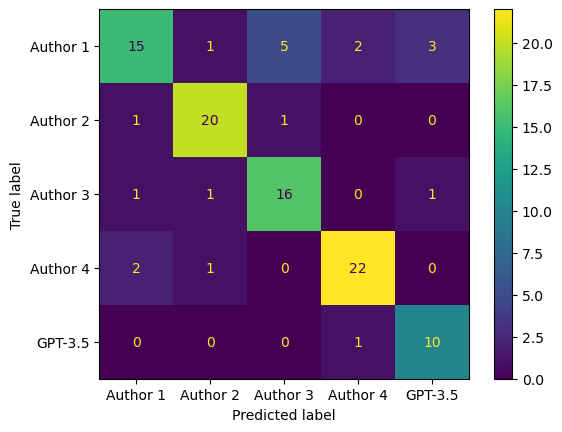

{'accuracy': 0.8058252427184466, 'recall': 0.8058252427184466, 'precision': 0.8058252427184466, 'f1': 0.8032086720867209}


In [97]:
plot_accuracy(df_test_final, 'prediction_RF', default_metrics)

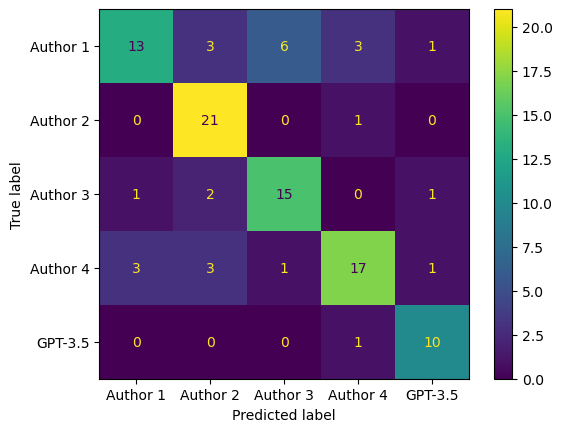

{'accuracy': 0.7378640776699029, 'recall': 0.7378640776699029, 'precision': 0.7378640776699029, 'f1': 0.7433250960562112}


In [98]:
plot_accuracy(df_test_final, 'prediction_RF_pca', default_metrics)

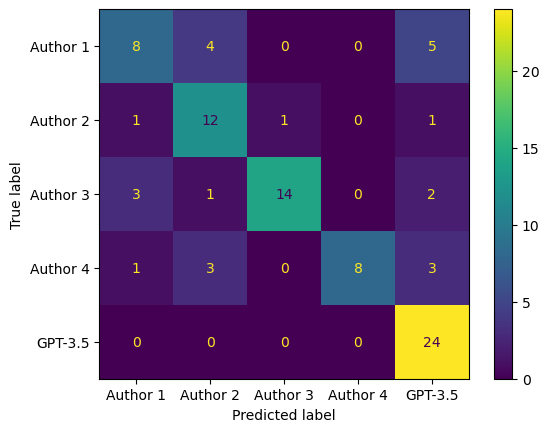

{'accuracy': 0.7252747252747253, 'recall': 0.7252747252747253, 'precision': 0.7252747252747253, 'f1': 0.7056518229989122}


In [99]:
plot_accuracy(df_test_1, 'prediction_SVC_pca', default_metrics)

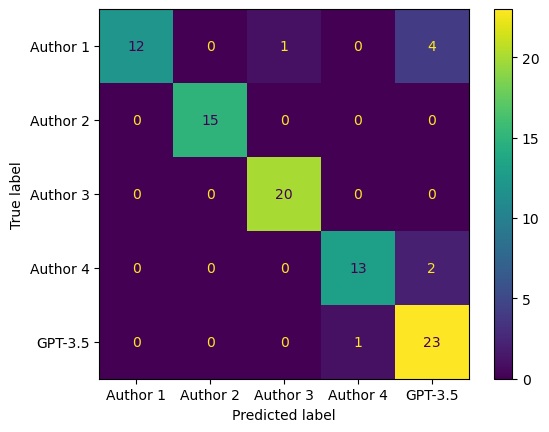

{'accuracy': 0.9120879120879121, 'recall': 0.9120879120879121, 'precision': 0.9120879120879121, 'f1': 0.913534443086786}


In [100]:
plot_accuracy(df_test_1, 'prediction_SVC', default_metrics)

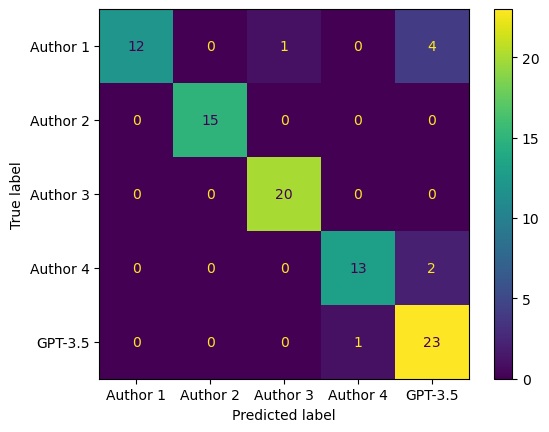

{'accuracy': 0.9120879120879121, 'recall': 0.9120879120879121, 'precision': 0.9120879120879121, 'f1': 0.913534443086786}


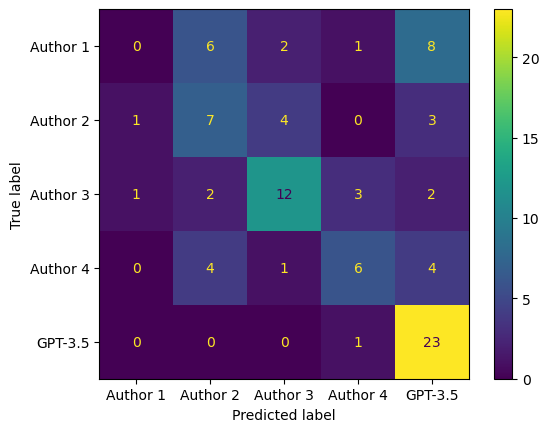

{'accuracy': 0.5274725274725275, 'recall': 0.5274725274725275, 'precision': 0.5274725274725275, 'f1': 0.44148755656108596}


In [101]:
plot_accuracy(df_test_1, 'prediction_LR', default_metrics)
plot_accuracy(df_test_1, 'prediction_LR_pca', default_metrics)

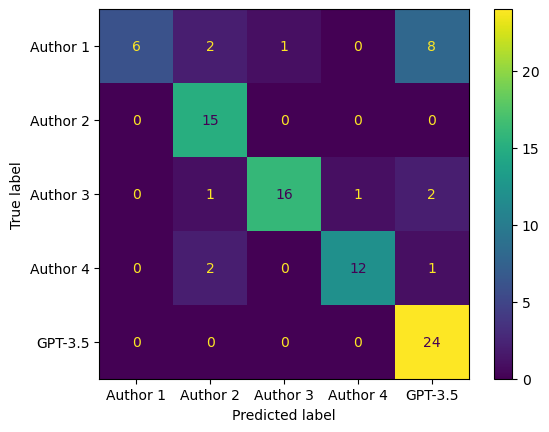

{'accuracy': 0.8021978021978022, 'recall': 0.8021978021978022, 'precision': 0.8021978021978022, 'f1': 0.782889806323852}


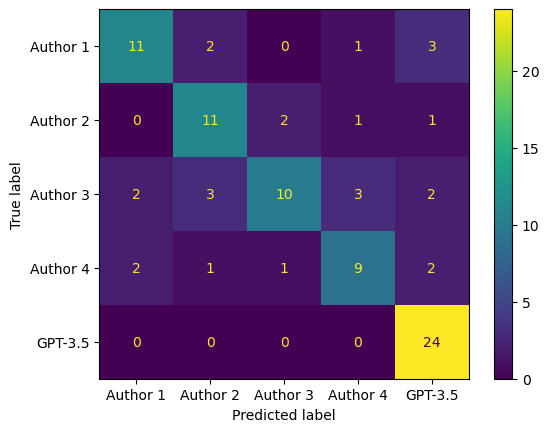

{'accuracy': 0.7142857142857143, 'recall': 0.7142857142857143, 'precision': 0.7142857142857143, 'f1': 0.6917786236751754}


In [102]:
plot_accuracy(df_test_1, 'prediction_RF', default_metrics)
plot_accuracy(df_test_1, 'prediction_RF_pca', default_metrics)

In [103]:
import eli5

In [104]:
colnames_reg_list = colnames_reg.tolist()

In [105]:
eli5.show_weights(LR_model, feature_names = colnames_reg_list)

In [106]:
predictions_LR_conclusion

array(['GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'Aman Madaan',
       'Aman Madaan', 'GPT-3.5', 'Aman Madaan', 'Timo Schick',
       'Aman Madaan', 'Aman Madaan', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'Aman Madaan', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Zhiqing Sun', 'GPT-3.5', 'Zhiqing Sun', 'Zhiqing Sun',
       'Zhiqing Sun', 'GPT-3.5', 'Zhiqing Sun', 'Zhiqing Sun',
       'Zhiqing Sun', 'Zhiqing Sun', 'Zhiqi

In [107]:
df_test_final = df_test_final.reset_index(drop = True)

In [108]:
df_test_final[df_test_final['Author'] == "GPT-3.5"]

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score_v2,word_count,sent_count,sybl_count,sent_score,...,lexical_diversity,avg_word_per_sentence,avg_word_length,ID,prediction_SVC,prediction_SVC_pca,prediction_RF,prediction_RF_pca,prediction_LR,prediction_LR_pca
11,10,GPT-3.5,"[' In the contemporary landscape, the influenc...",abstract_chunked,"In the contemporary landscape, the influence ...",13.855678,249.0,12.0,506.0,0.530392,...,0.565371,23.583333,5.992933,10,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
13,14,GPT-3.5,[' Supervised Fine-Tuning (SFT) in conjunction...,intro_chunked,Supervised Fine-Tuning (SFT) in conjunction w...,30.365000,168.0,6.0,294.0,0.536131,...,0.597701,29.000000,5.528736,100,Zhiqing Sun,GPT-3.5,Zhiqing Sun,GPT-3.5,Zhiqing Sun,GPT-3.5
16,4,GPT-3.5,[' In the realm of natural language processing...,intro_chunked,"In the realm of natural language processing, ...",26.421471,170.0,7.0,313.0,0.730229,...,0.670213,26.857143,5.765957,90,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
25,23,GPT-3.5,[' The fusion of pretrained language models wi...,intro_chunked,The fusion of pretrained language models with...,18.279286,140.0,5.0,265.0,0.778760,...,0.647059,30.600000,5.823529,109,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
38,18,GPT-3.5,"["" Collaborative writing involves a dynamic pr...",abstract_chunked,Collaborative writing involves a dynamic proc...,30.831866,134.0,7.0,248.0,0.652488,...,0.610063,22.714286,5.484277,18,Timo Schick,GPT-3.5,GPT-3.5,GPT-3.5,Timo Schick,GPT-3.5
49,20,GPT-3.5,[' While some natural language processing (NLP...,abstract_chunked,While some natural language processing (NLP) ...,37.441866,121.0,6.0,213.0,0.572715,...,0.648855,21.833333,5.717557,20,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
55,14,GPT-3.5,[' Supervised Fine-Tuning (SFT) on response de...,abstract_chunked,Supervised Fine-Tuning (SFT) on response demo...,31.330695,187.0,7.0,328.0,0.614621,...,0.578680,28.142857,5.664975,14,Zhiqing Sun,GPT-3.5,GPT-3.5,Zhiqing Sun,Zhiqing Sun,GPT-3.5
56,17,GPT-3.5,[' Natural Language Processing (NLP) has made ...,intro_chunked,Natural Language Processing (NLP) has made re...,31.360201,149.0,7.0,271.0,0.636048,...,0.664634,23.428571,5.762195,103,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
58,22,GPT-3.5,[' This paper introduces an innovative approac...,abstract_chunked,This paper introduces an innovative approach ...,23.485784,111.0,5.0,211.0,0.541911,...,0.697479,23.800000,6.050420,22,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
60,18,GPT-3.5,"["" Despite the collaborative nature of writing...",intro_chunked,Despite the collaborative nature of writing p...,23.149615,156.0,7.0,297.0,0.649570,...,0.631285,25.571429,5.553073,104,Timo Schick,GPT-3.5,GPT-3.5,GPT-3.5,Timo Schick,GPT-3.5


In [109]:
eli5.show_weights(RF_model, feature_names = colnames_reg_list, top = 20)

Weight,Feature
0.0063 ± 0.0460,avg_word_length
0.0056 ± 0.0465,flesch_score_v2
0.0034 ± 0.0305,pos_noun punct verb
0.0033 ± 0.0256,stop_the
0.0030 ± 0.0285,word_image
0.0029 ± 0.0240,stop_this
0.0028 ± 0.0226,word_language
0.0028 ± 0.0231,pos_noun pron
0.0027 ± 0.0234,pos_pron aux
0.0027 ± 0.0226,lexical_diversity


In [110]:
df_test_final

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score_v2,word_count,sent_count,sybl_count,sent_score,...,lexical_diversity,avg_word_per_sentence,avg_word_length,ID,prediction_SVC,prediction_SVC_pca,prediction_RF,prediction_RF_pca,prediction_LR,prediction_LR_pca
0,160,Zhiqing Sun,"[' Unlike English and many other languages, Ch...",intro_chunked,There is a trivial way to extend these statist...,40.226683,195.0,8.0,327.0,0.288862,...,0.517949,24.375000,5.256410,246,Zhiqing Sun,Aman Madaan,Zhiqing Sun,Zhiqing Sun,Zhiqing Sun,Zhiqing Sun
1,201,Timo Schick,[' Semantic representations of natural languag...,intro_chunked,We proceed as follows: After giving a succinct...,41.248268,154.0,6.0,254.0,0.536461,...,0.520958,27.833333,4.790419,287,Hugo Touvron,Aman Madaan,Hugo Touvron,Hugo Touvron,Hugo Touvron,Aman Madaan
2,63,Aman Madaan,[' Politeness plays a crucial role in social i...,intro_chunked,"Additionally, unlike previous systems, the out...",56.562747,280.0,13.0,425.0,0.651160,...,0.495082,23.461538,4.793443,149,Aman Madaan,Aman Madaan,Aman Madaan,Aman Madaan,Aman Madaan,Hugo Touvron
3,42,Hugo Touvron,"[' We introduce LLaMA, a collection of foundat...",abstract_chunked,"We introduce LLaMA, a collection of foundatio...",51.547917,81.0,4.0,129.0,0.774183,...,0.606742,29.666667,5.000000,42,Hugo Touvron,Hugo Touvron,Aman Madaan,Hugo Touvron,Hugo Touvron,Timo Schick
4,73,Hugo Touvron,[' Large Languages Models (LLMs) trained on ma...,intro_chunked,Large Languages Models (LLMs) trained on mass...,56.110455,220.0,7.0,309.0,0.282326,...,0.502242,22.300000,4.695067,159,Timo Schick,Hugo Touvron,Timo Schick,Hugo Touvron,Timo Schick,Hugo Touvron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,58,Zhiqing Sun,"[' Recent AI-assistant agents, such as ChatGPT...",abstract_chunked,"Recent AI-assistant agents, such as ChatGPT, ...",16.495833,325.0,6.0,520.0,0.597764,...,0.516035,49.000000,5.186589,58,Zhiqing Sun,Zhiqing Sun,Zhiqing Sun,Hugo Touvron,Zhiqing Sun,Zhiqing Sun
99,166,Timo Schick,[' Large language models achieve impressive ze...,intro_chunked,"Therefore, we propose Toolformer, a model that...",58.417149,221.0,7.0,304.0,0.526671,...,0.537815,34.000000,4.521008,252,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick
100,81,Timo Schick,[' Learning high-quality embeddings for rare w...,abstract_chunked,Learning high-quality embeddings for rare wor...,44.555479,142.0,5.0,224.0,0.428236,...,0.585526,30.400000,4.848684,81,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick
101,25,Aman Madaan,[' Human problem-solving inherently follows a ...,intro_chunked,"However, modern LLM often provide access solel...",36.302310,207.0,8.0,353.0,0.214813,...,0.624454,28.625000,5.393013,111,Aman Madaan,Aman Madaan,Timo Schick,Timo Schick,Aman Madaan,Zhiqing Sun


In [111]:
colnames_reg_list = colnames_reg.to_list()
eli5.show_prediction(RF_model, X_test_scaled[100], top =20, feature_names = colnames_reg_list)

In [112]:
df_test_1

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score_v2,word_count,sent_count,sybl_count,sent_score,...,lexical_diversity,avg_word_per_sentence,avg_word_length,ID,prediction_SVC,prediction_SVC_pca,prediction_RF,prediction_RF_pca,prediction_LR,prediction_LR_pca
288,0,GPT-3.5,[' AutoMix emerges as a promising solution in ...,conclusion_chunked,AutoMix emerges as a promising solution in th...,31.674179,133.0,6.0,240.0,0.805644,...,0.614865,24.666667,5.513514,288,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
289,1,GPT-3.5,"[' In this study, we introduced SELF-REFINE, a...",conclusion_chunked,"In this study, we introduced SELF-REFINE, a n...",31.277097,155.0,5.0,264.0,0.800223,...,0.613095,33.600000,5.529762,289,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,Zhiqing Sun
290,2,GPT-3.5,"[' In this work, we introduced FLOWGEN, a grap...",conclusion_chunked,"In this work, we introduced FLOWGEN, a graph ...",38.154241,116.0,5.0,199.0,0.702326,...,0.722222,25.200000,5.317460,290,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
291,3,GPT-3.5,"[' In this work, we introduced a method for cu...",conclusion_chunked,"In this work, we introduced a method for cura...",29.207988,123.0,6.0,228.0,0.765929,...,0.702290,26.200000,5.877863,291,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
292,4,GPT-3.5,"[' In conclusion, this paper introduces and ad...",conclusion_chunked,"In conclusion, this paper introduces and addr...",22.339375,128.0,4.0,230.0,0.850744,...,0.692857,35.000000,5.628571,292,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,86,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,We have devised a novel approach for the chal...,47.359467,183.0,6.0,278.0,0.628488,...,0.541237,32.333333,5.015464,374,Timo Schick,Aman Madaan,Timo Schick,Aman Madaan,Timo Schick,Timo Schick
375,87,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,As an exhaustive search for the highest-scorin...,45.234107,210.0,8.0,335.0,0.494213,...,0.619469,45.200000,4.960177,375,Timo Schick,Timo Schick,Hugo Touvron,Zhiqing Sun,Timo Schick,Timo Schick
376,88,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,This result strongly suggests that our transit...,50.941739,207.0,7.0,308.0,0.469552,...,0.561086,27.625000,4.764706,376,Timo Schick,Timo Schick,Timo Schick,Hugo Touvron,Timo Schick,Timo Schick
377,89,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,"Of course, such a revision does not\nhave to b...",33.436547,179.0,5.0,290.0,0.464467,...,0.632768,35.400000,4.943503,377,Timo Schick,Aman Madaan,Timo Schick,Zhiqing Sun,Timo Schick,Zhiqing Sun


# Agglomerative clustering

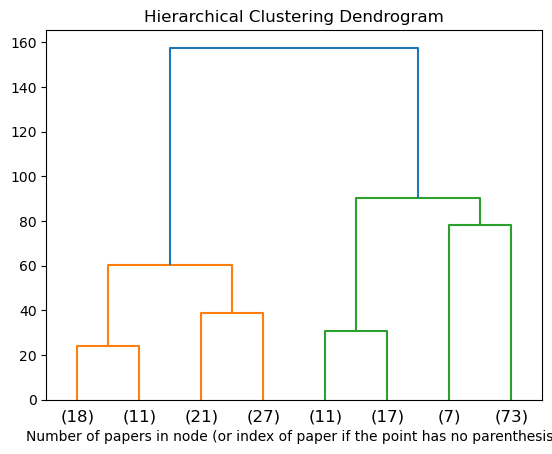

In [113]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold = 0, n_clusters=None)

model = model.fit(X_train_df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of papers in node (or index of paper if the point has no parenthesis).")
plt.show()

In [116]:
eli5.show_prediction(RF_model, df_test_1.loc[312])

ValueError: feature_names has a wrong length: expected=42855, got=22

In [118]:
eli5.show_prediction(RF_model, X_test_1_scaled[24], top =20, feature_names = colnames_reg_list)

42855


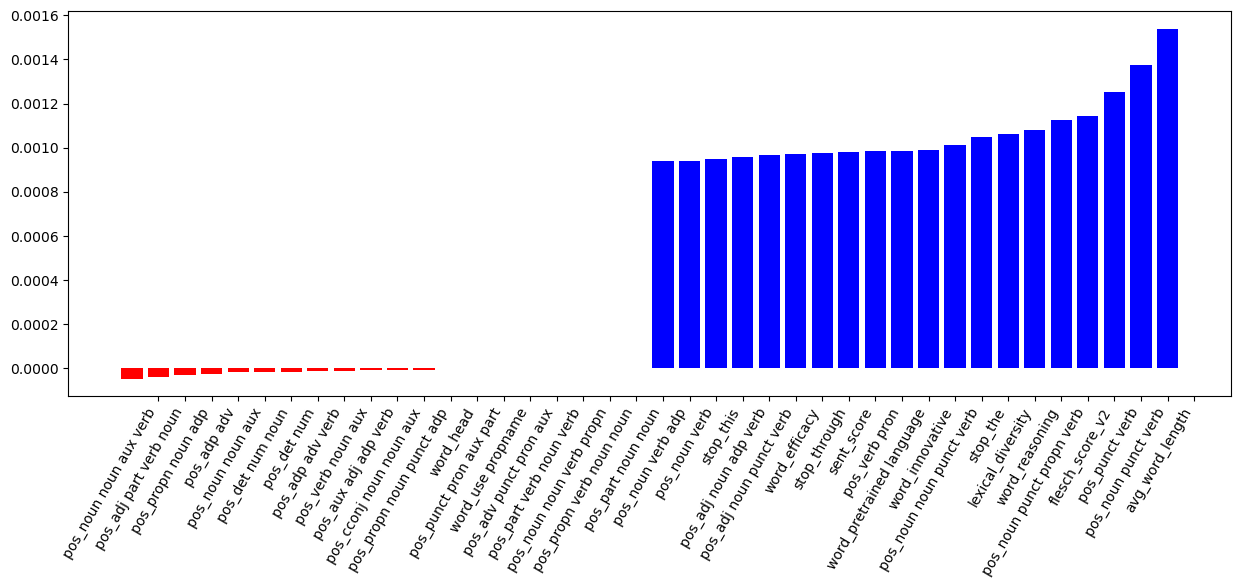

In [131]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = np.max(classifier.coef_, axis=0).ravel()
 print (len(coef))
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()
plot_coefficients(SVC_model, feature_names)